<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_NNDL_P8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set random seeds for reproducibility
np.random.seed(8)
tf.random.set_seed(8)

def load_and_preprocess_mnist():
    """Load and preprocess MNIST dataset"""
    # Load MNIST dataset
    (x_train, _), (x_test, _) = mnist.load_data()

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # Reshape data for CNN
    x_train_cnn = x_train.reshape(-1, 28, 28, 1)
    x_test_cnn = x_test.reshape(-1, 28, 28, 1)

    # Reshape data for LSTM
    x_train_lstm = x_train.reshape(-1, 28, 28)
    x_test_lstm = x_test.reshape(-1, 28, 28)

    return (x_train_cnn, x_test_cnn), (x_train_lstm, x_test_lstm)


In [ ]:
def build_cnn_autoencoder():
    """Build CNN autoencoder model"""
    # Input
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 14x14

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 7x7

    # Bottleneck
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)  # 7x7x8

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 14x14

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 28x28

    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create and compile model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

def build_lstm_autoencoder():
    """Build LSTM autoencoder model"""
    # Encoder
    input_seq = Input(shape=(28, 28))

    # Encoding layers
    x = LSTM(128, return_sequences=True)(input_seq)
    x = LSTM(64, return_sequences=True)(x)
    encoded = LSTM(32, return_sequences=False)(x)

    # Decoding layers
    x = RepeatVector(28)(encoded)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(128, return_sequences=True)(x)
    decoded = TimeDistributed(Dense(28))(x)

    # Create and compile model
    autoencoder = Model(input_seq, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder


In [ ]:
def visualize_reconstructions(original, reconstructed, n=10, title=""):
    """Visualize original and reconstructed images"""
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title('Original' if i == 0 else '')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed' if i == 0 else '')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title)
    plt.show()

def plot_training_history(history, model_type):
    """Plot training history"""
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Autoencoder Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
print("Loading and preprocessing MNIST dataset...")
(x_train_cnn, x_test_cnn), (x_train_lstm, x_test_lstm) = load_and_preprocess_mnist()


Loading and preprocessing MNIST dataset...


In [ ]:
print("\nTraining CNN Autoencoder...")
cnn_autoencoder = build_cnn_autoencoder()
cnn_history = cnn_autoencoder.fit(
        x_train_cnn, x_train_cnn,
        epochs=5,
        batch_size=256,
        validation_data=(x_test_cnn, x_test_cnn),
        verbose=1)


Training CNN Autoencoder...
Epoch 1/5
235/235 [==============================] - 24s 93ms/step - loss: 0.0463 - val_loss: 0.0817
Epoch 2/5
235/235 [==============================] - 22s 92ms/step - loss: 0.0105 - val_loss: 0.0146
Epoch 3/5
235/235 [==============================] - 22s 92ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 4/5
235/235 [==============================] - 22s 93ms/step - loss: 0.0061 - val_loss: 0.0071
Epoch 5/5
235/235 [==============================] - 22s 94ms/step - loss: 0.0052 - val_loss: 0.0056


313/313 [==============================] - 2s 6ms/step

CNN Autoencoder MSE: 0.005641


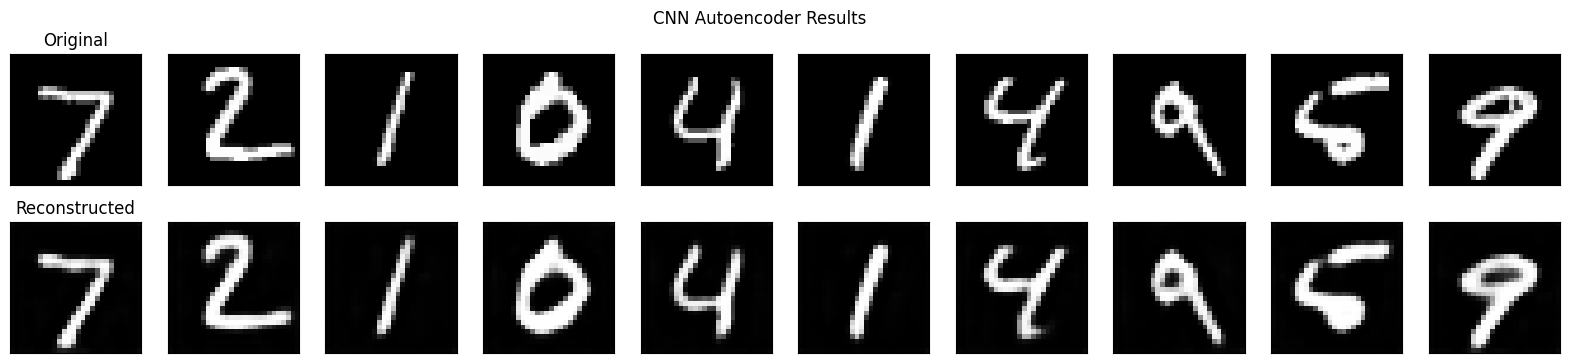

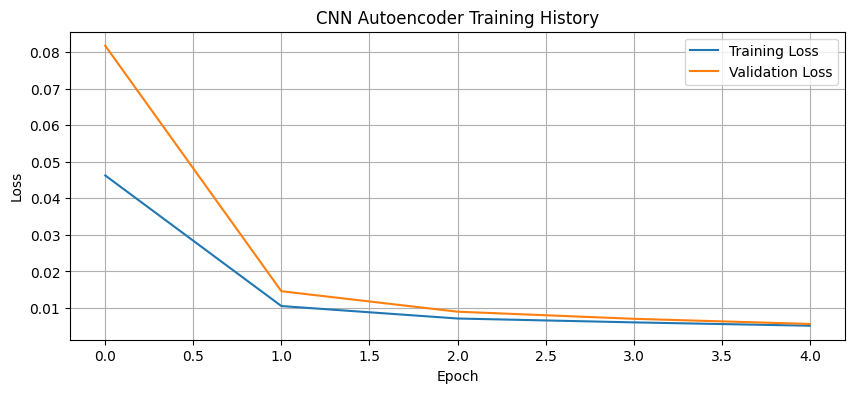

In [ ]:
# Evaluate and visualize CNN results
cnn_reconstructed = cnn_autoencoder.predict(x_test_cnn)
cnn_mse = np.mean((x_test_cnn - cnn_reconstructed) ** 2)
print(f"\nCNN Autoencoder MSE: {cnn_mse:.6f}")
visualize_reconstructions(x_test_cnn, cnn_reconstructed, title="CNN Autoencoder Results")
plot_training_history(cnn_history, "CNN")

In [ ]:
# LSTM Autoencoder
print("\nTraining LSTM Autoencoder...")
lstm_autoencoder = build_lstm_autoencoder()
lstm_history = lstm_autoencoder.fit(
        x_train_lstm, x_train_lstm,
        epochs=5,
        batch_size=256,
        validation_data=(x_test_lstm, x_test_lstm),
        verbose=1
    )




Training LSTM Autoencoder...
Epoch 1/5
235/235 [==============================] - 71s 275ms/step - loss: 0.0543 - val_loss: 0.0398
Epoch 2/5
235/235 [==============================] - 64s 271ms/step - loss: 0.0337 - val_loss: 0.0277
Epoch 3/5
235/235 [==============================] - 63s 266ms/step - loss: 0.0248 - val_loss: 0.0216
Epoch 4/5
207/235 [=========================>....] - ETA: 6s - loss: 0.0206

In [ ]:
# Evaluate and visualize LSTM results
lstm_reconstructed = lstm_autoencoder.predict(x_test_lstm)
lstm_mse = np.mean((x_test_lstm - lstm_reconstructed) ** 2)
print(f"\nLSTM Autoencoder MSE: {lstm_mse:.6f}")
visualize_reconstructions(x_test_lstm, lstm_reconstructed, title="LSTM Autoencoder Results")
plot_training_history(lstm_history, "LSTM")

In [ ]:
def compare_autoencoders(cnn_model, lstm_model, x_test_cnn, x_test_lstm):
    print("\nPart 3: Comparison and Discussion")
    print("==================================")

    # 1. Feature Extraction Efficiency
    print("\n1. Feature Extraction Efficiency:")
    print("--------------------------------")

    # Get reconstructions
    cnn_reconstructed = cnn_model.predict(x_test_cnn)
    lstm_reconstructed = lstm_model.predict(x_test_lstm)

    # Calculate reconstruction errors
    cnn_mse = np.mean((x_test_cnn - cnn_reconstructed) ** 2)
    lstm_mse = np.mean((x_test_lstm - lstm_reconstructed) ** 2)

    print(f"CNN Reconstruction MSE: {cnn_mse:.6f}")
    print(f"LSTM Reconstruction MSE: {lstm_mse:.6f}")

    # 2. Dimensionality Reduction Analysis
    print("\n2. Dimensionality Reduction Analysis:")
    print("------------------------------------")
    print(f"Original image dimensions: 28x28 = {28*28} dimensions")
    print(f"CNN bottleneck dimensions: 7x7x8 = {7*7*8} dimensions")
    print(f"LSTM bottleneck dimensions: 32 dimensions")

    compression_ratio_cnn = (28 * 28) / (7 * 7 * 8)
    compression_ratio_lstm = (28 * 28) / 32

    print(f"\nCompression Ratios:")
    print(f"CNN Compression Ratio: {compression_ratio_cnn:.2f}:1")
    print(f"LSTM Compression Ratio: {compression_ratio_lstm:.2f}:1")

    # 4. Computational Efficiency
    print("\n3. Model Complexity Comparison:")
    print("------------------------------")
    cnn_params = cnn_model.count_params()
    lstm_params = lstm_model.count_params()

    print(f"CNN Parameters: {cnn_params:,}")
    print(f"LSTM Parameters: {lstm_params:,}")

    # 5. Visualization of comparison
    plt.figure(figsize=(15, 5))

    # Plot sample reconstructions side by side
    plt.subplot(131)
    plt.imshow(x_test_cnn[0].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(cnn_reconstructed[0].reshape(28, 28), cmap='gray')
    plt.title('CNN Reconstruction')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(lstm_reconstructed[0].reshape(28, 28), cmap='gray')
    plt.title('LSTM Reconstruction')
    plt.axis('off')

    plt.suptitle('Visual Comparison of Reconstructions')
    plt.show()


Performing Comparative Analysis...

Part 3: Comparison and Discussion

1. Feature Extraction Efficiency:
--------------------------------
313/313 [==============================] - 8s 27ms/step
CNN Reconstruction MSE: 0.003535
LSTM Reconstruction MSE: 0.017612

2. Dimensionality Reduction Analysis:
------------------------------------
Original image dimensions: 28x28 = 784 dimensions
CNN bottleneck dimensions: 7x7x8 = 392 dimensions
LSTM bottleneck dimensions: 32 dimensions

Compression Ratios:
CNN Compression Ratio: 2.00:1
LSTM Compression Ratio: 24.50:1

4. Model Complexity Comparison:
------------------------------
CNN Parameters: 12,585
LSTM Parameters: 269,468


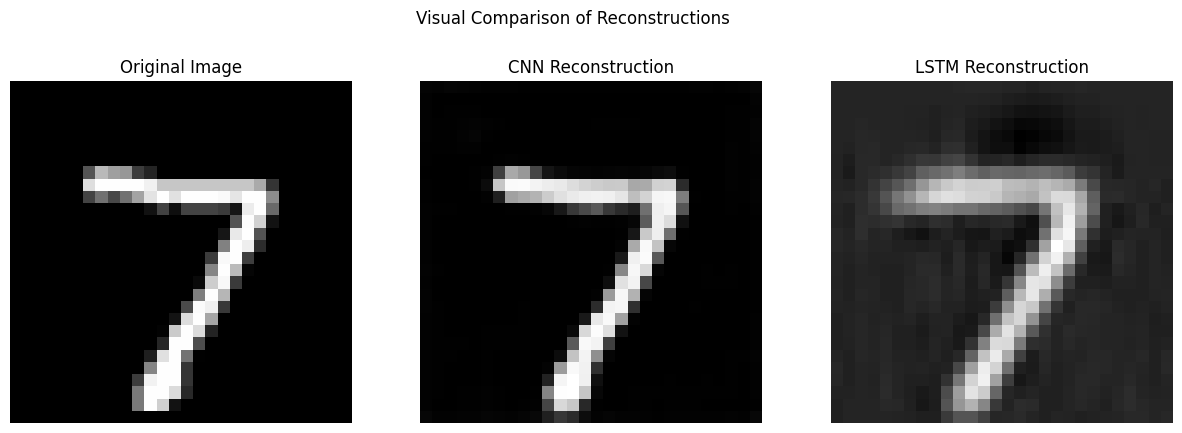


Summary of Findings:
1. Spatial vs Sequential Processing:
   - CNN better preserves spatial features
   - LSTM better captures sequential patterns

2. Compression Efficiency:
   - CNN provides more efficient compression for image data
   - LSTM offers flexible sequence encoding

3. Application Suitability:
   - CNN: Preferred for image-related tasks
   - LSTM: Better for sequential data processing


In [ ]:
print("\nPerforming Comparative Analysis...")
compare_autoencoders(cnn_autoencoder, lstm_autoencoder, x_test_cnn, x_test_lstm)

# Summary
print("\nSummary of Findings:")
print("===================")
print("1. Spatial vs Sequential Processing:")
print("   - CNN better preserves spatial features")
print("   - LSTM better captures sequential patterns")

print("\n2. Compression Efficiency:")
print("   - CNN provides more efficient compression for image data")
print("   - LSTM offers flexible sequence encoding")

print("\n3. Application Suitability:")
print("   - CNN: Preferred for image-related tasks")
print("   - LSTM: Better for sequential data processing")